In [1]:
import os
import re
import subprocess
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.environ["SLURM_TIME_FORMAT"] = "%s"

In [3]:
def get_data_from_sacct(clusters: str,
                        start_date: str,
                        end_date: str,
                        users: str,
                        fields: str) -> pd.DataFrame:
    """Return a dataframe of the sacct output."""
    cmd = f"sacct -M {clusters} -X -P -n -S {start_date} -E {end_date} -a -A rosengroup -o {fields}"
    output = subprocess.run(cmd,
                            stdout=subprocess.PIPE,
                            shell=True,
                            timeout=100,
                            text=True,
                            check=True)
    rows = [row.split("|") for row in output.stdout.split()]
    df = pd.DataFrame(rows)
    df.columns = fields.split(",")
    return df

In [4]:
def gpus_per_job(tres: str) -> int:
    """Return the number of allocated GPUs."""
    gpus = re.findall(r"gres/gpu=\d+", tres)
    return int(gpus[0].replace("gres/gpu=", "")) if gpus else 0

In [5]:
def clean_dataframe(df):
    for col in ["elapsedraw", "start", "eligible"]:
        df = df[pd.notna(df[col])]
        df = df[df[col].str.isnumeric()]
        df[col] = df[col].astype("int64")
    df = df[df.elapsedraw > 0]
    df.cputimeraw = df.cputimeraw.astype("int64")
    df["gpus"] = df.alloctres.apply(gpus_per_job)
    df["gpu-seconds"] = df.apply(lambda row:
                                 row["gpus"] * row["elapsedraw"]
                                 if row["partition"] != "mig"
                                 else row["gpus"] * row["elapsedraw"] / 7,
                                 axis="columns")
    return df

In [6]:
clusters = "della"
#users = "asrosen,as7959,bd8619,ho0950,jb8648,ng8249,sc4997,vineetb"
users = ""
fields = "user,cputimeraw,elapsedraw,start,eligible,alloctres,partition"

In [7]:
days_per_period = 14
total_days_from_today = 120
periods = total_days_from_today // days_per_period + 1

In [8]:
end_dates = []
q_hours = []
cpu_hours = []
gpu_hours = []
print("start", "end", "Q-hours", "CPU-hours", "GPU-hours")
for i in range(periods):
    start_date = datetime.now() - timedelta(days=(i+1) * days_per_period - 1)
    end_date   = start_date + timedelta(days=days_per_period - 1)
    s = datetime.strftime(start_date, "%Y-%m-%d")
    e = datetime.strftime(end_date,   "%Y-%m-%d")
    df = get_data_from_sacct(clusters, s, e, users, fields)
    df = clean_dataframe(df)
    df["q-seconds"] = df.start - df.eligible
    qhrs = round(df["q-seconds"].sum() / 3600)
    chrs = round(df["cputimeraw"].sum() / 3600)
    ghrs = round(df["gpu-seconds"].sum() / 3600)
    print(s, e, qhrs, chrs, ghrs)
    #print(df.groupby("user").agg({"q-seconds":"sum", "cputimeraw":"sum", "gpu-seconds":"sum"}))
    end_dates.append(end_date)
    q_hours.append(qhrs)
    cpu_hours.append(chrs)
    gpu_hours.append(ghrs)

start end Q-hours CPU-hours GPU-hours
2026-01-10 2026-01-23 837 14167 1699
2025-12-27 2026-01-09 121 59124 6152
2025-12-13 2025-12-26 53 13436 6589
2025-11-29 2025-12-12 45 1391 513
2025-11-15 2025-11-28 7548 1923 158
2025-11-01 2025-11-14 24362 3718 1468
2025-10-18 2025-10-31 35439 4111 2958
2025-10-04 2025-10-17 17773 32671 2029
2025-09-20 2025-10-03 1852 6145 1049


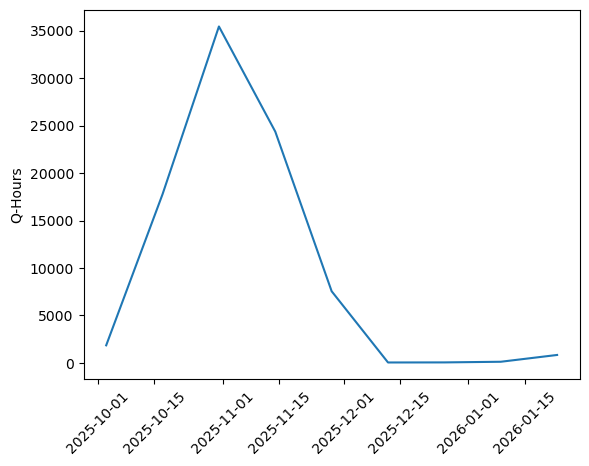

In [9]:
fig, ax = plt.subplots()
plt.plot(end_dates, q_hours)
ax.tick_params(axis='x', labelrotation=45)
_ = plt.ylabel("Q-Hours")

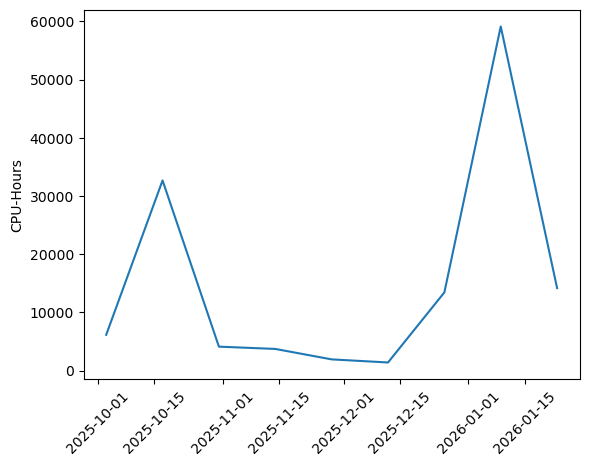

In [10]:
fig, ax = plt.subplots()
plt.plot(end_dates, cpu_hours)
ax.tick_params(axis='x', labelrotation=45)
_ = plt.ylabel("CPU-Hours")

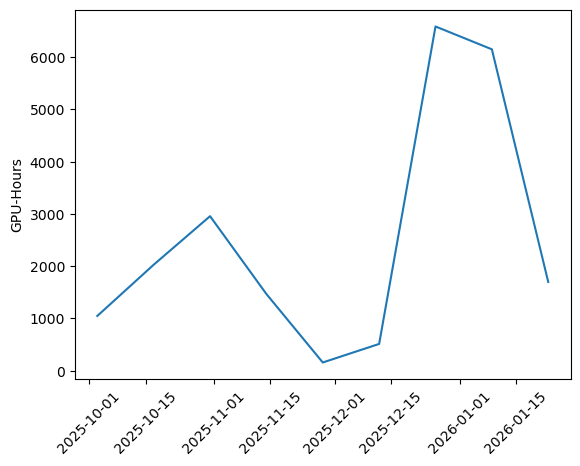

In [11]:
fig, ax = plt.subplots()
plt.plot(end_dates, gpu_hours)
ax.tick_params(axis='x', labelrotation=45)
_ = plt.ylabel("GPU-Hours")